In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from datetime import datetime

import tarfile
import gzip
import os
import xml.etree.ElementTree as ET

import load_functions as lf

# Load data

## Movie Summaries

In [100]:
data_folder = './data/MovieSummaries/'
(movie_metadata, character_metadata, name_clusters, plot_summaries, test_data) = \
    lf.load_movie_summaries(data_folder)

# add release year (float) to movie_metadata, extracting it from release_date
movie_metadata['release_year'] = movie_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add lowecase title to movie_metadata
movie_metadata['lowercase_title'] = movie_metadata['movie_name'].str.lower()

# add release year (float) to character_metadata, extracting it from release_date
character_metadata['release_year'] = character_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add actor birth year (float) to character_metadata, extracting it from actor_birth_date
character_metadata['actor_birth_year'] = character_metadata['actor_birth_date'].apply(lambda x: lf.extract_year(x))

In [101]:
'''
Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
10. Movie release year
'''
movie_metadata.head()

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,release_year,lowercase_title
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,ghosts of mars
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,getting away with murder: the jonbenét ramsey ...
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,brun bitter
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0,white of the eye
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,a woman in flames


In [102]:
'''
Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID
'''
character_metadata.head()

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,1974.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,1969.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,1967.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,1977.0


In [103]:
'''
970 unique character names used in at least two different movies, along with 2,666 instances of those types.
The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.
'''
name_clusters.head()

,character_name,free_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [104]:
'''
Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.
Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.
'''
plot_summaries.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [16]:
'''
72 character types drawn from tvtropes.com, along with 501 instances of those types.
The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.
'''
test_data.head()                                         

,character_type,dictionary,character_name,movie_name,free_character_actor_map_id,actor_name
0,absent_minded_professor,"{'char': 'Professor Philip Brainard', 'movie':...",Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,"{'char': 'Professor Keenbean', 'movie': 'Richi...",Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,"{'char': 'Dr. Reinhardt Lane', 'movie': 'The S...",Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,"{'char': 'Dr. Harold Medford', 'movie': 'Them!...",Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,"{'char': 'Daniel Jackson', 'movie': 'Stargate'...",Daniel Jackson,Stargate,/m/0k3rhh,James Spader


## CoreNLP PLot Summaries

In [44]:
'''
The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref).
Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).
'''

data_folder = './data/corenlp_plot_summaries/'
df = pd.read_xml(data_folder + '330.xml.gz', compression='gzip',) # NaN

'''
# error
directory = './data/corenlp_plot_summaries/'
gz_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.gz')]
data_frames = []
for gz_file in gz_files:
    with gzip.open(gz_file) as f:
        df = pd.read_csv(f, compression='gzip')
        data_frames.append(df)
'''

df.head()

,sentences,coreference
0,NaN,NaN


In [45]:
# manual parsing ...

# Parse the XML data
f = gzip.open(data_folder + '330.xml.gz')
tree = ET.parse(f)
root = tree.getroot()

# Create empty lists to store the data
data = {
    'word': [],
    'lemma': [],
    'CharacterOffsetBegin': [],
    'CharacterOffsetEnd': [],
    'POS': [],
    'NER': [],
}

# Iterate through the XML structure to extract the data
for token in root.findall(".//token"):
    data['word'].append(token.find('word').text)
    data['lemma'].append(token.find('lemma').text)
    data['CharacterOffsetBegin'].append(int(token.find('CharacterOffsetBegin').text))
    data['CharacterOffsetEnd'].append(int(token.find('CharacterOffsetEnd').text))
    data['POS'].append(token.find('POS').text)
    data['NER'].append(token.find('NER').text)

# Create a DataFrame from the extracted data
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

,word,lemma,CharacterOffsetBegin,CharacterOffsetEnd,POS,NER
0,In,in,0,2,IN,O
1,order,order,3,8,NN,O
2,to,to,9,11,TO,O
3,prepare,prepare,12,19,VB,O
4,the,the,20,23,DT,O


# Basic features analysis

## Undestanding the dataset

In [9]:
character_metadata.loc[character_metadata['character_name'] == 'Stuart Little']

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id
73642,2394008,/m/078z_r,1999-12-05,Stuart Little,1961-06-09,M,1.63,/m/0g8_vp,Michael J. Fox,38.0,/m/0k3w9c,/m/0bvsxxm,/m/0hz_1
144807,750694,/m/0386bw,2002-07-19,Stuart Little,1961-06-09,M,1.63,/m/0g8_vp,Michael J. Fox,41.0,/m/0k3wbn,/m/0bvsxxm,/m/0hz_1
428789,3885386,/m/0b51yw,2005-02-21,Stuart Little,1961-06-09,M,1.63,/m/0g8_vp,Michael J. Fox,43.0,/m/0k3wcx,/m/0bvsxxm,/m/0hz_1


In [184]:
print('unique values of freebase character/actor map ID')
print(len(character_metadata['free_character_actor_map_id'].unique()))
print('\nfreebase character/actor map ID')
print(len(character_metadata['free_character_actor_map_id']))

# column 11. Freebase character/actor map ID: unique value for each row
# used in name_clusters, test_data to map the corresponding row in character_metadata

unique values of freebase character/actor map ID
450669

freebase character/actor map ID
450669


In [183]:
print('unique values of freebase movie ID in character_metadata')
print(len(character_metadata['free_movie_id'].unique()))
print('\nfreebase movie ID')
print(len(character_metadata['free_movie_id']))

unique values of freebase movie ID in character_metadata
64330

freebase movie ID
450669


In [181]:
print('unique values of freebase character ID in character_metadata')
print(len(character_metadata['free_character_id'].unique()))
print('\nfreebase character ID')
print(len(character_metadata['free_character_id']))

unique values of freebase character ID in character_metadata
183436

freebase character ID
450669


In [187]:
print('unique values of freebase actor ID in character_metadata')
print(len(character_metadata['free_actor_id'].unique()))
print('\nfreebase actor ID')
print(len(character_metadata['free_actor_id']))

unique values of freebase actor ID in character_metadata
135761

freebase actor ID
450669


In [224]:
print('unique values of actor ethnicity in character_metadata')
print(len(character_metadata['actor_ethnicity'].unique()))
print('\nactor ethnicity')
print(len(character_metadata['actor_ethnicity']))

unique values of actor ethnicity in character_metadata
480

actor ethnicity
450669


In [58]:
print('number of nan values in movie_metadata:')
print(movie_metadata.isna().sum())

print('\nnumber of rows in movie_metadata')
print(movie_metadata.shape[0])

# a lot of box_office_revenue NaN

number of nan values in movie_metadata:
wiki_movie_id             0
free_movie_id             0
movie_name                0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
release_year           6902
lowercase_title           0
dtype: int64

number of rows in movie_metadata
81741


In [115]:
print('number of nan values in character_metadata:')
print(character_metadata.isna().sum())

print('\nnumber of rows in character_metadata')
print(character_metadata.shape[0])

number of nan values in character_metadata:
wiki_movie_id                       0
free_movie_id                       0
release_date                     9995
character_name                 257875
actor_birth_date               106145
actor_gender                    45609
actor_height                   295845
actor_ethnicity                344611
actor_name                       1228
actor_age                      158113
free_character_actor_map_id         0
free_character_id              257865
free_actor_id                     815
release_year                     9995
actor_birth_year               106156
dtype: int64

number of rows in character_metadata
450669


## Plot data

### Movies metadata

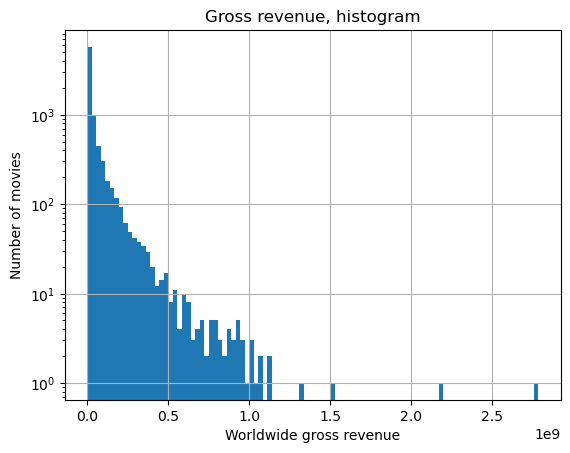

In [83]:
# gross revenue histogram
movie_metadata['box_office_revenue'].dropna().hist(bins = 100, log=True)
plt.xlabel('Worldwide gross revenue')
plt.ylabel('Number of movies')
plt.title('Gross revenue, histogram');

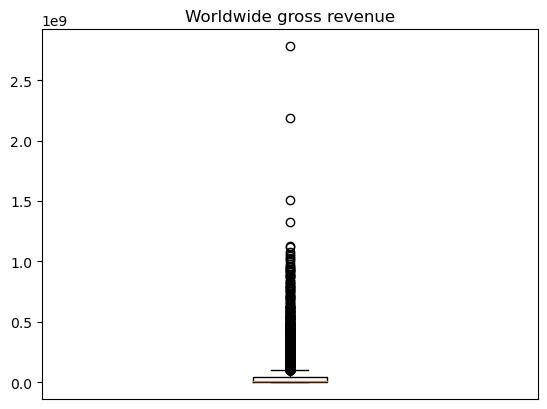

In [105]:
# gross revenue box plot
plt.boxplot(movie_metadata['box_office_revenue'].dropna())
plt.xticks([])
plt.title('Worldwide gross revenue');

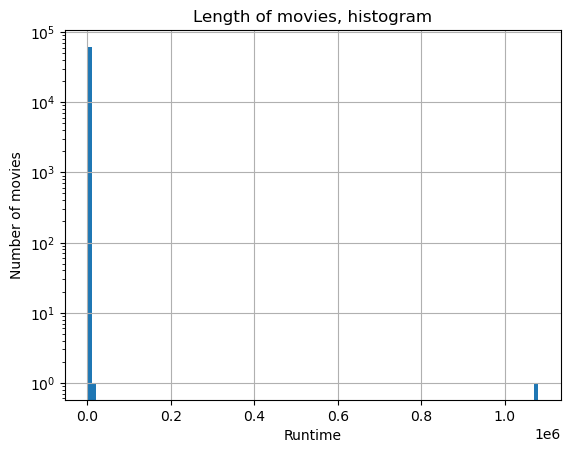

In [82]:
# runtime histogram
movie_metadata['runtime'].dropna().hist(bins = 100, log=True)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.title('Length of movies, histogram');

In [80]:
movie_metadata[movie_metadata['runtime'] > 14000]
# movie 10815585, error runtime

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,release_year,lowercase_title
12804,10815585,/m/02qqy23,Zero Tolerance,1995,NaN,1079281.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1995.0,zero tolerance
62962,32441022,/m/0gyr803,Modern Times Forever,NaN,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}",NaN,modern times forever


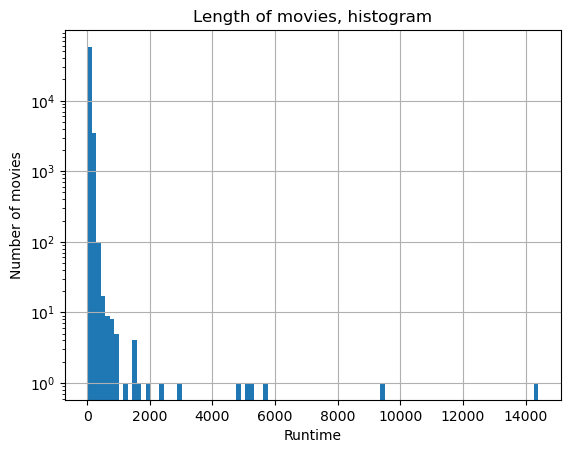

In [81]:
# drop the error and replot
movie_metadata[movie_metadata['runtime'] < 1079280].runtime.dropna().hist(bins = 100, log=True)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.title('Length of movies, histogram');

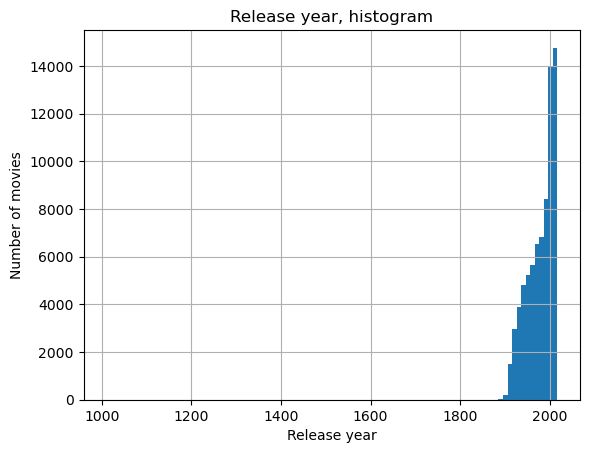

In [84]:
# release year histogram
movie_metadata['release_year'].dropna().hist(bins = 100, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');

In [106]:
movie_metadata[movie_metadata['release_year'] < 1890]
# movie 62836, error release_year

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,release_year,lowercase_title
38764,12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",1889,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1889.0,"leisurely pedestrians, open topped buses and h..."
57963,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1888.0,roundhay garden scene
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.00,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...",1010.0,hunting season


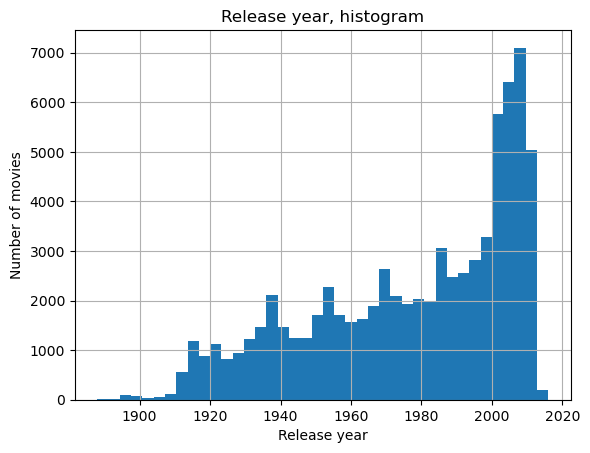

In [110]:
# drop the error and replot
movie_metadata[movie_metadata['release_year'] > 1011].release_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');

### Characters metadata

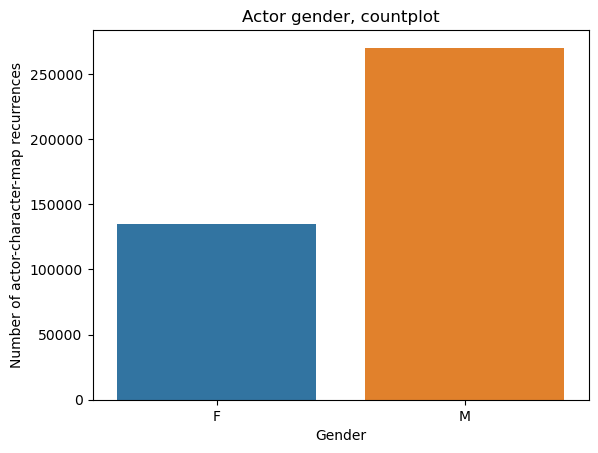

In [198]:
character_metadata
sns.countplot(data=character_metadata, x="actor_gender");
plt.title('Actor gender, countplot')
plt.xlabel('Gender')
plt.ylabel('Number of actor-character-map recurrences');

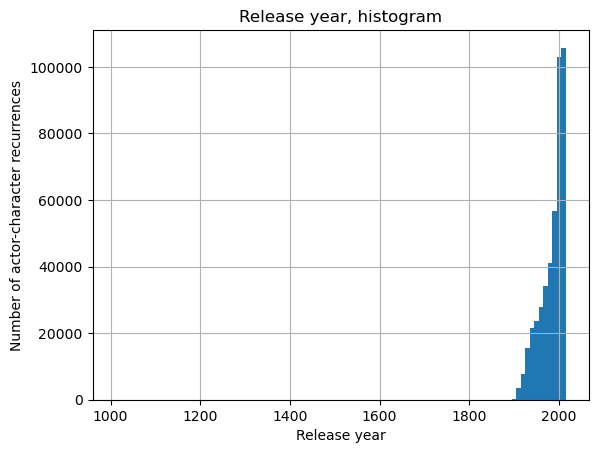

In [199]:
# release year histogram
character_metadata['release_year'].dropna().hist(bins = 100, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Release year, histogram');

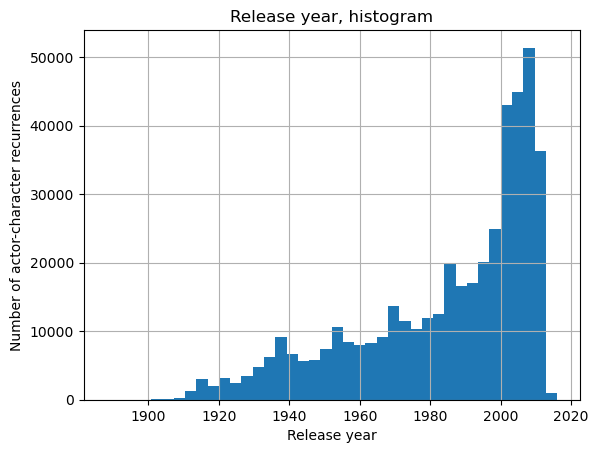

In [200]:
# drop the error
character_metadata[character_metadata['release_year'] > 1011].release_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Release year, histogram');
# consistent with the above plot

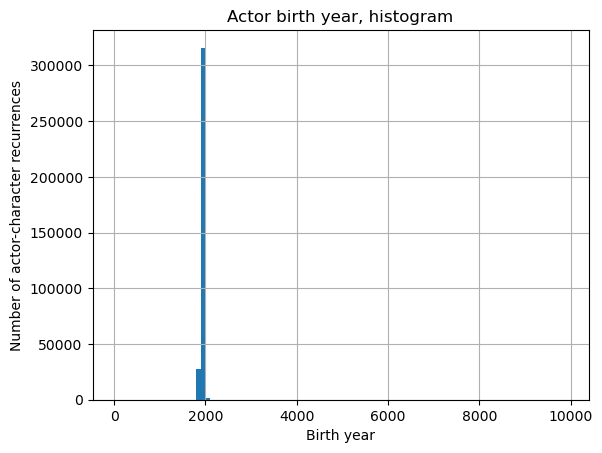

In [201]:
# actor birth year histogram
character_metadata['actor_birth_year'].dropna().hist(bins = 100, log=False)
plt.xlabel('Birth year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actor birth year, histogram');

In [202]:
character_metadata[character_metadata['actor_birth_year'] < 1830]
# Leo Tolstoy, error to be dropped
# Mammy Lou, ok

# temp: consider > 1828

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
11550,21038272,/m/05b268g,1979,NaN,1498,F,NaN,NaN,Mirabai,NaN,/m/05cnn3x,NaN,/m/03h165,1979.0,1498.0
39427,5419425,/m/0dl0sj,2007-02-12,NaN,0019-11-28,NaN,NaN,NaN,Leland L. Jones,-12.0,/m/0gdl7t6,NaN,/m/0273sb0,2007.0,19.0
42283,2541685,/m/07lyw_,1993-06-16,NaN,0019-10-30,NaN,1.82,NaN,Dale Gibson,-26.0,/m/0gcjqyb,NaN,/m/0gcjqyg,1993.0,19.0
45080,2244529,/m/06yt3z,2003,NaN,0019-03-22,F,NaN,NaN,Julie Stevens,-16.0,/m/0bff0wc,NaN,/m/06p14x,2003.0,19.0
80339,997174,/m/03xvc7,2001-11-02,NaN,0019-11-28,NaN,NaN,NaN,Leland L. Jones,-18.0,/m/0647261,NaN,/m/0273sb0,2001.0,19.0
92871,20072112,/m/04n46f5,2008,NaN,1075-08-19,F,NaN,NaN,Holly Eglington,NaN,/m/0gc7_rh,NaN,/m/0gc64t0,2008.0,1075.0
107166,33952827,/m/0hnbcn2,2010,NaN,0852-03-10,M,NaN,NaN,Qian Liu,NaN,/m/0n64v09,NaN,/m/07gkxv,2010.0,852.0
133189,34340896,/m/02qlltk,1896-09,NaN,1829-02-20,M,NaN,NaN,Joseph Jefferson,NaN,/m/02vbcpt,NaN,/m/02nbtt,1896.0,1829.0
137376,2236014,/m/06y5dn,1999,NaN,0195-02-07,F,1.67,NaN,Mónica Dionne,NaN,/m/09hyqcq,NaN,/m/02rvvq3,1999.0,195.0
155798,8060931,/m/026q2k7,NaN,NaN,0183,M,NaN,NaN,Lu Xun,NaN,/m/02vcff3,NaN,/m/01x879,NaN,183.0


In [203]:
character_metadata[character_metadata['actor_birth_year'] > 2007]
# let consider <= 2008

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
72697,1693867,/m/05nyqk,2000-10-06,Thorpey,2011-09-02,M,1.75,/m/05sf2x,John Cassini,-10.0,/m/0cpb70c,/m/0cpb70g,/m/0flhn7,2000.0,2011.0
85104,34537226,/m/0h1zb6y,2012-01-25,Henry Cozy,2008-01-10,M,NaN,NaN,Finn Donoghue,4.0,/m/0hh6zhj,/m/0hh6zhm,/m/0hh6zhv,2012.0,2008.0
134870,24358829,/m/07s47x7,2008,NaN,2011-09-02,M,1.75,/m/05sf2x,John Cassini,-3.0,/m/0cw0l0f,NaN,/m/0flhn7,2008.0,2011.0
195142,32298508,/m/0gx_t8p,2011-09-09,Troy,2008-10-29,M,NaN,NaN,Owen Bento,2.0,/m/0ghv2ln,/m/0ghv2k9,/m/0ghv2k6,2011.0,2008.0
279068,789903,/m/03cd0x,2004-07-23,Graphologist,2011-09-02,M,1.75,/m/05sf2x,John Cassini,-7.0,/m/0cg99h8,/m/0h5nsmf,/m/0flhn7,2004.0,2011.0
299570,4198361,/m/0bphhp,2005-12-15,Bernie Callo,2011-09-02,M,1.75,/m/05sf2x,John Cassini,-5.0,/m/0cg48_3,/m/0h5shrm,/m/0flhn7,2005.0,2011.0
300065,22643470,/m/05zqsh4,1926-10-29,NaN,2896-04-26,M,NaN,NaN,Matthieu van Eysden,-969.0,/m/0n1fz80,NaN,/m/0jt60hb,1926.0,2896.0
314756,29114879,/m/0dlmnlr,2010,NaN,2011-09-02,M,1.75,/m/05sf2x,John Cassini,-1.0,/m/0gm1jq0,NaN,/m/0flhn7,2010.0,2011.0
322333,10240061,/m/02q674n,2004,NaN,9900-09-07,F,NaN,NaN,Kimberly Jones,-7896.0,/m/02vcpws,NaN,/m/0cc1lj,2004.0,9900.0
345994,34654608,/m/0j26ybm,2012-02-04,NaN,2050,M,NaN,NaN,Naozumi Takahashi,-37.0,/m/0n9z5lz,NaN,/m/044pxh,2012.0,2050.0


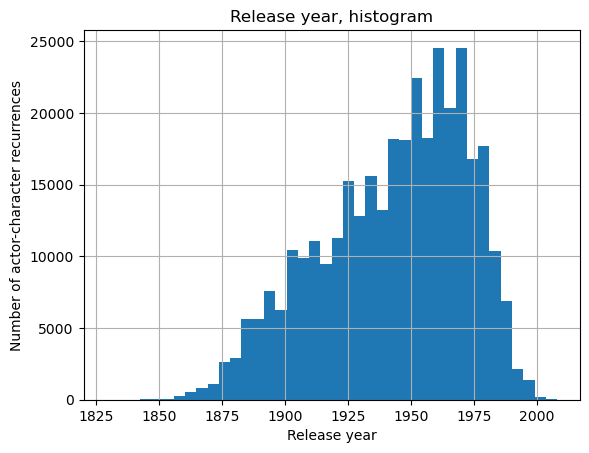

In [204]:
# temp drop the error
character_metadata[(character_metadata['actor_birth_year'] > 1828) * (character_metadata['actor_birth_year'] < 2009)].actor_birth_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Release year, histogram');

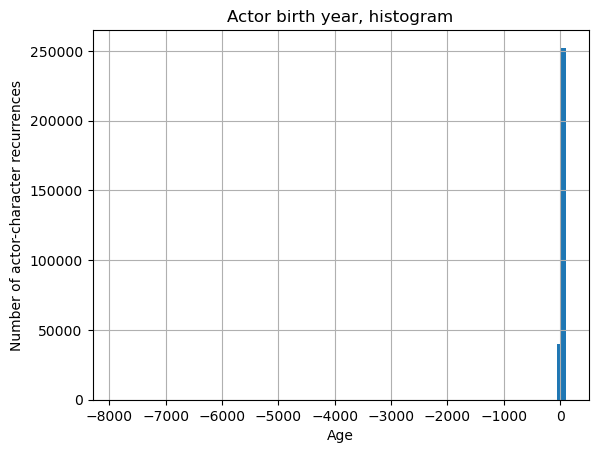

In [205]:
# actor age histogram
character_metadata['actor_age'].dropna().hist(bins = 100, log=False)
plt.xlabel('Age')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actor birth year, histogram');

In [206]:
character_metadata[character_metadata['actor_age'] < 0]

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
767,15007384,/m/03h4h5p,1934-05-02,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3,NaN,/m/01wlly9,1934.0,1963.0
2286,2553539,/m/07mlsy,1918-04-14,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1,NaN,/m/0382zh,1918.0,1931.0
3892,5917218,/m/0fdf3y,1965,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf,NaN,/m/03pjkv,1965.0,1983.0
6666,73930,/m/0jsjm,1924,Robert,1972-11-07,M,1.80,NaN,Jason London,-48.0,/m/01xrptw,/m/02nwfsk,/m/04kdmg,1924.0,1972.0
7188,21242801,/m/05bzjwj,1955-08-07,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f,NaN,/m/0bkkw0,1955.0,1973.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446570,3642891,/m/09rsyj,1999-10-03,Tess,2936-12-24,F,NaN,NaN,J.J. McColl,-937.0,/m/0l2rdfz,/m/0l2rdg1,/m/0l2rdg8,1999.0,2936.0
446581,25868401,/m/09v6ykm,1955,NaN,1967-05-31,F,1.67,/m/03ts0c,Sandrine Bonnaire,-12.0,/m/04j05tr,NaN,/m/07wn_5,1955.0,1967.0
446583,8595532,/m/02799cv,1944-02-23,NaN,1947-05-28,M,NaN,NaN,Kevin O'Shea,-3.0,/m/02vcqnq,NaN,/m/02q384f,1944.0,1947.0
446816,1276915,/m/04pg6m,1941-06-20,NaN,1957-04-19,M,NaN,NaN,Tony Martin,-15.0,/m/0cg164j,NaN,/m/07q_fg,1941.0,1957.0


In [207]:
character_metadata[character_metadata['actor_age'] > 100]

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
230088,30241563,/m/0g59rl8,2004,NaN,1900-12-20,M,NaN,NaN,Lokesh,103.0,/m/0jx7c12,NaN,/m/0bbz0rv,2004.0,1900.0
407572,34362803,/m/0h_chfy,2012-03-06,NaN,1908-05-30,M,NaN,/m/041rx,Mel Blanc,103.0,/m/0mzkr96,NaN,/m/0c5vh,2012.0,1908.0


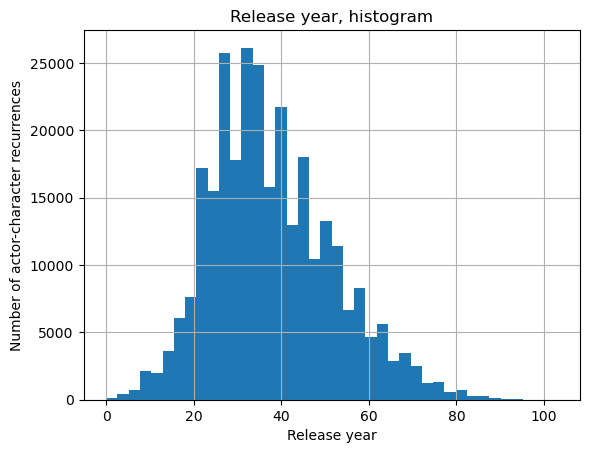

In [208]:
# drop the error, replot
character_metadata[character_metadata['actor_age'] >= 0].actor_age.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Release year, histogram');

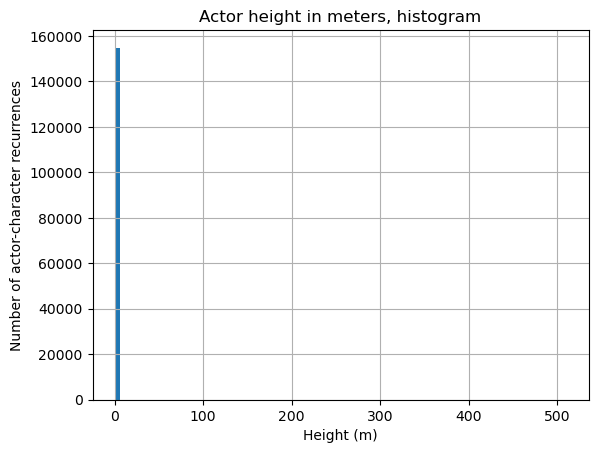

In [210]:
# actor height histogram
character_metadata['actor_height'].dropna().hist(bins = 100, log=False)
plt.xlabel('Height (m)')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actor height in meters, histogram');

In [214]:
character_metadata[character_metadata['actor_height'] <= 0]

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year


In [220]:
character_metadata[character_metadata['actor_height'] > 3]

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
21619,1291587,/m/04qk12,2004-09-01,young Georgie,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,18.0,/m/0k276dx,/m/0k276dz,/m/0bggwvl,2004.0,1986.0
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0,1998.0,1972.0
59719,12206655,/m/02vvw24,NaN,Dominic,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,NaN,/m/0k276dq,/m/0h8hcr1,/m/0bggwvl,NaN,1986.0
104140,17999628,/m/047n_2q,1998,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0,1998.0,1972.0
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0,2003.0,1972.0
219383,179326,/m/018gq3,1996-11-18,Herbert,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,10.0,/m/0bggwv8,/m/0bggwvc,/m/0bggwvl,1996.0,1986.0
301653,4667507,/m/0cg9n6,2001-11-29,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,28.0,/m/0cg0zwp,NaN,/m/08hqh0,2001.0,1972.0
316621,3915041,/m/0b6lyp,2002,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,29.0,/m/02vc5p5,NaN,/m/08hqh0,2002.0,1972.0
341890,29290087,/m/0b3w9mr,1997-04-07,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,24.0,/m/0gvwy8x,NaN,/m/08hqh0,1997.0,1972.0
360967,14413223,/m/03d2rnl,2012-04-20,Young Punk Guy,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,26.0,/m/0m4q87d,/m/0k9tfs8,/m/0bggwvl,2012.0,1986.0


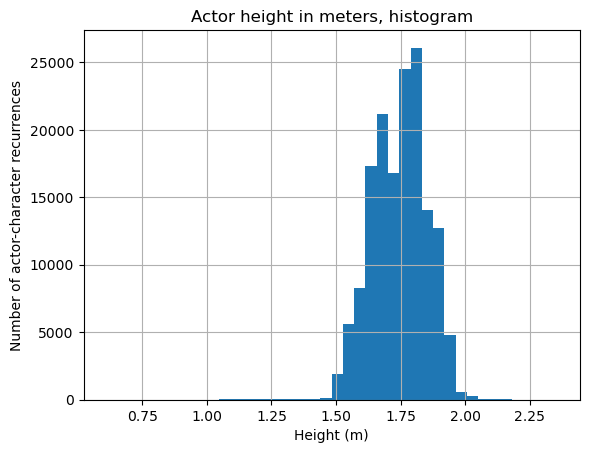

In [221]:
# drop the error, replot
character_metadata[character_metadata['actor_height'] < 3].actor_height.dropna().hist(bins = 40, log=False)
plt.xlabel('Height (m)')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actor height in meters, histogram');

# Enrich the dataset

In [95]:
data_folder = './data/'
test = pd.read_csv(data_folder + 'test.csv')
test['lowercase_title'] = test['original_title'].str.lower()

train = pd.read_csv(data_folder + 'train.csv')
train['lowercase_title'] = train['original_title'].str.lower()

In [60]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,lowercase_title
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",ディアルガvsパルキアvsダークライ
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",attack of the 50 foot woman
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...",addicted to love
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de...",incendies
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de...",inside deep throat


In [61]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,lowercase_title
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,hot tub time machine 2
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,the princess diaries 2: royal engagement
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,whiplash
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,kahaani
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,마린보이


In [63]:
print(train.shape)
print(test.shape)

(3000, 24)
(4398, 23)


In [64]:
test.isin(movie_metadata.lowercase_title).lowercase_title.sum()

0

In [65]:
train.isin(movie_metadata.lowercase_title).lowercase_title.sum()

0